# Regresja logistyczna z walidacją krzyżową
Regresja logistyczna jest metodą klasyfikującą dane, których odpowiedzi przyjmują dwie wartości.

## Import bibliotek i wczytanie danych

Wykorzystany zostanie zbiór danych [titanic](data/titanic/), pobrany ze strony [kaggle.com](https://www.kaggle.com/c/titanic/data).

Jest on podzielony na dwa pliki: train.csv i test.csv. Plik testowy nie zawiera etykiet, więc nie może zostać wykorzystany do walidacji modelu. Dokonam dla niego predykcji, a skuteczność modelu oblicze poprzez wydzielenie części danych ze zbioru treningowego.

Zadaniem modelu będzie przewidzenie czy osoba przeżyła katastrofę Tytanica.

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

train_data = pd.read_csv("data/titanic/train.csv")
test_data = pd.read_csv("data/titanic/test.csv")

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Przygotowanie danych

Z obu zbiorów pozbywam się kolumn niskoskorelowanych oraz rekordów z pustymi wartościami.

In [2]:
for df in [train_data, test_data]:
    df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin", "Parch", "SibSp"], inplace=True)
    df.dropna(subset=["Age", "Embarked", "Fare"], inplace=True)
    df["Sex"] = df["Sex"].map({"male": 0, "female": 1})

Dodatkowo zamieniam wartości kolumn **Sex** i **Embarked** na liczbowe odpowiedniki.

In [3]:
train_data = pd.get_dummies(train_data, columns=["Embarked"])
test_data = pd.get_dummies(test_data, columns=["Embarked"])

x = train_data.drop(columns=["Survived"])
y = train_data["Survived"]

## Trening modelu

Przed rozpoczęciem treningu dokonuję walidacji krzyżowej za pomocą klasy **KFold**. Walidacja krzyżowa pozwala na dokładniejsze oszacowanie wydajności modelu, ponieważ model jest testowany na różnych częściach danych, co zmniejsza ryzyko, że wynik będzie zależny od tego, jak dane zostały podzielone.

In [4]:
kfold = KFold()

for fold, (train_index, test_index) in enumerate(kfold.split(x)):
    print(f"Trening foldu {fold+1}...")
    x_train_cv = x.iloc[train_index]
    x_test_cv = x.iloc[test_index]
    y_train_cv = y.iloc[train_index]
    y_test_cv = y.iloc[test_index]

    model = Pipeline([
        ('scaler', StandardScaler()),
        ('logi_reg', LogisticRegression())
    ])
    model.fit(x_train_cv, y_train_cv)

    print(f"Uzyskana dokładność foldu {fold+1}: {model.score(x_test_cv, y_test_cv)}\n")


Trening foldu 1...
Uzyskana dokładność foldu 1: 0.7552447552447552

Trening foldu 2...
Uzyskana dokładność foldu 2: 0.7972027972027972

Trening foldu 3...
Uzyskana dokładność foldu 3: 0.7676056338028169

Trening foldu 4...
Uzyskana dokładność foldu 4: 0.7535211267605634

Trening foldu 5...
Uzyskana dokładność foldu 5: 0.8098591549295775



Do wytrenowania modelu, który zostanie wykorzystany do predykcji danych testowych wykorzystam cały zbiór treningowy.

In [5]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('logi_reg', LogisticRegression())
])
model.fit(x, y)

,steps,"[('scaler', ...), ('logi_reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


## Predykcja zbioru testowego

Predykcji dokonuje za pomocą metody **predict()**. Otrzymaną tablicę zer i jedynek umieszczam w nowym Dataframe razem z kolumną **Sex** zbioru testowego. Dzięki temu mogę dokonać analizy przeżywalności z podziałem na płeć.

In [6]:
y_pred = model.predict(test_data)

sex = test_data["Sex"].map({0: "Male", 1: "Female"})
survived = np.vectorize(lambda x: "No" if x == 0 else "Yes")(y_pred)

data = pd.DataFrame({"Sex": sex, "Survived": survived})
data.value_counts()

Sex     Survived
Male    No          187
Female  Yes         114
Male    Yes          17
Female  No           13
Name: count, dtype: int64

Otrzymane wartości mogę przedstawić w formie graficznej. 

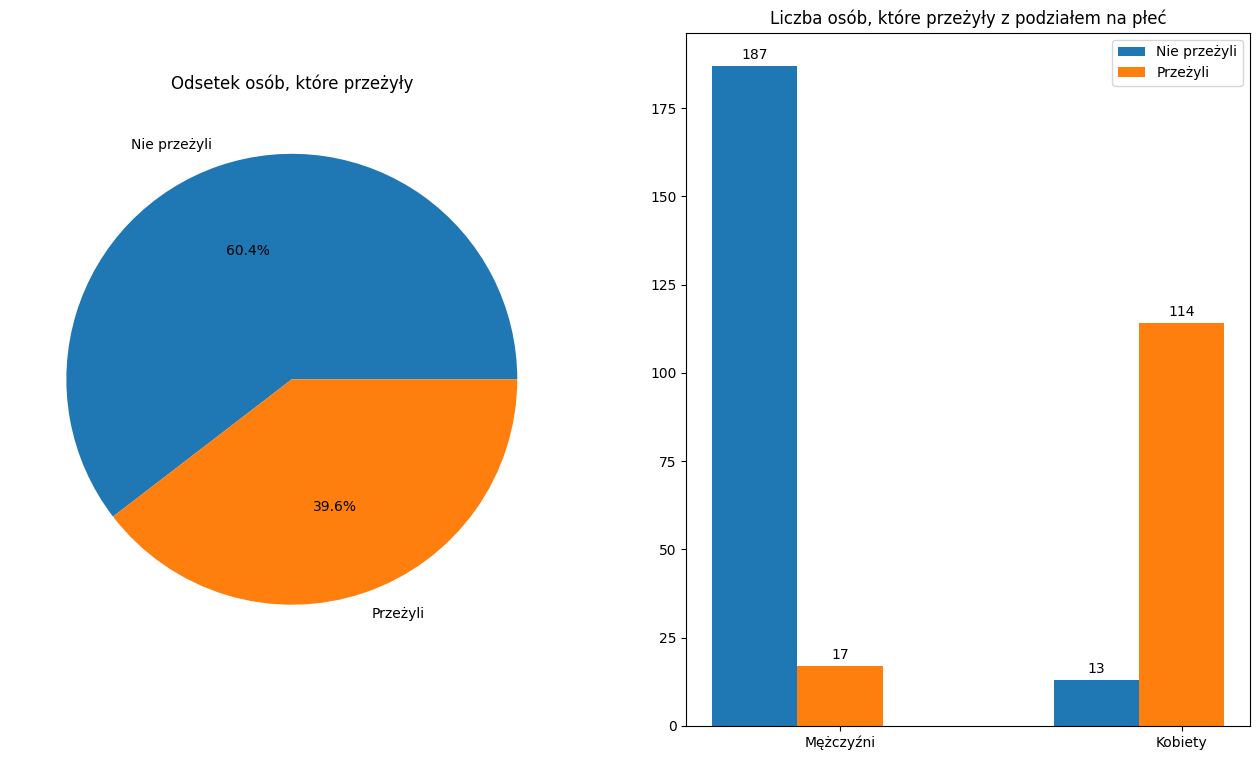

In [7]:
counts = pd.crosstab(data['Survived'], columns='count').values.ravel()

fig, ax = plt.subplots(1, 2, figsize=(16, 9))
ax[0].pie(counts, labels=["Nie przeżyli", "Przeżyli"], autopct='%1.1f%%')
ax[0].set_title("Odsetek osób, które przeżyły")

species = ("Mężczyźni", "Kobiety")
survived_sex = {
    'Nie przeżyli': (data.value_counts()['Male']['No'], data.value_counts()['Female']['No']),
    'Przeżyli': (data.value_counts()['Male']['Yes'], data.value_counts()['Female']['Yes']),
}

x = np.arange(len(species))
width = 0.25
multiplier = 0

for attribute, measurement in survived_sex.items():
    offset = width * multiplier
    rects = ax[1].bar(x + offset, measurement, width, label=attribute)
    ax[1].bar_label(rects, padding=3)
    multiplier += 1

ax[1].set_xticks(x + width, species)
ax[1].set_title("Liczba osób, które przeżyły z podziałem na płeć")
ax[1].legend()

plt.show()